# Setup

In [ ]:
!pip install imblearn
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 36.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 127.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 41.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [ ]:
random_state = 4

In [ ]:
#read in data
df = pd.read_csv('df_phen_presence.csv')
df

,First_bloom,First_leaf,Phenophase,avg_precip,avg_tmax,avg_tmin,avg_srad
0,0.0,0.0,0.0,0.894000,-0.962333,-12.123333,206.480000
1,0.0,0.0,0.0,0.894000,-1.317000,-12.430000,207.782333
2,0.0,0.0,0.0,0.894000,-1.607333,-12.810333,211.193000
3,0.0,0.0,0.0,0.894000,-1.803333,-12.977000,212.198333
4,0.0,0.0,0.0,0.894000,-1.938333,-12.965333,211.908000
...,...,...,...,...,...,...,...
684137,0.0,0.0,0.0,6.833667,7.903667,1.311333,138.872000
684138,0.0,0.0,0.0,6.833667,7.584333,0.934333,140.276667
684139,0.0,0.0,0.0,6.833667,7.458667,0.627333,143.195333
684140,0.0,0.0,0.0,6.833667,7.322000,0.557667,142.423333


# Train, Test, Validate Split

In [ ]:
#making a custom function to product a validate set 
def train_validate_test_split(df, train_percent=.7, validate_percent=.15, seed=random_state):
    np.random.seed(seed)
    perm = np.random.permutation(df.index) #randomize the df
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test


In [ ]:
train, validate, test = train_validate_test_split(df)

# Class Imbalances

There is an imbalance in 0, 1, and 2 distribution because there is only a single 1 and 2 per plant per year. This can lead the model to just predict 0 by default to increase its accuracy. To account for this, we will use Synthetic Minority Oversampling Technique.

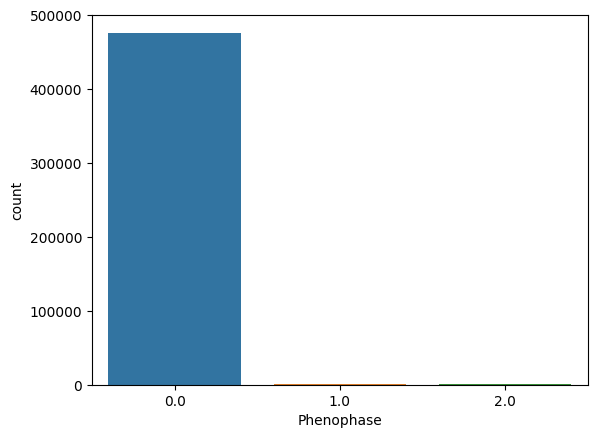

In [ ]:
sns.countplot(x = "Phenophase",data=train)
plt.show()

In [ ]:
#SMOTE
ph_y_train_0 = train['Phenophase']
ph_X_train_0 = train.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)
smote = SMOTE(random_state=random_state)
ph_X_train, ph_y_train = smote.fit_resample(ph_X_train_0, ph_y_train_0)
print(f'''Shape of X before SMOTE: {ph_X_train_0.shape}
Shape of X after SMOTE: {ph_X_train.shape}''')

Shape of X before SMOTE: (478899, 4)
Shape of X after SMOTE: (1428834, 4)


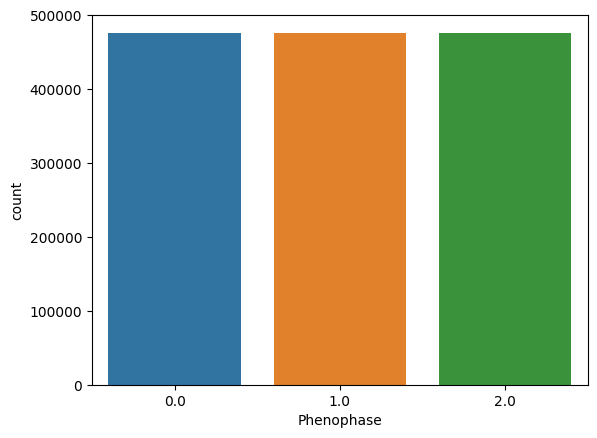

In [ ]:
sm_train = pd.concat([ph_y_train, ph_X_train], axis=1)
sns.countplot(x = "Phenophase",data=sm_train)
plt.show()

In [ ]:
#splitting validate and test sets
ph_y_validate = validate['Phenophase']
ph_X_validate = validate.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)

ph_y_test = test['Phenophase']
ph_X_test = test.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)

# KNeighbors

We will evaluate neighbors' values to determine what is the optimum classification. Per empiric recommendation, it is better to use an odd number of neighbors in case of tiebreakers. Two different weights, "Uniform" and "Distance", and a range of the number of neighbors will be evaluated.  

In [ ]:
#Scaling data
scaler = StandardScaler()
knn_X_train = scaler.fit_transform(ph_X_train)
knn_X_validate = scaler.transform(ph_X_validate)
knn_X_test = scaler.transform(ph_X_test)

In [ ]:
neighbors1 = [1, 11]
neighbors2 = list(range(101, 1101, 100))
n_neighbors = neighbors1 + neighbors2

In [ ]:
#distance weights runs out of ram after 701 neighbors, so removing 901 and 1001 for that model
#this is acceptable as the final # of neighbors used is likely in the 400-700 range
n_neighbors2 = n_neighbors.copy()
n_neighbors2.remove(801)
n_neighbors2.remove(901)
n_neighbors2.remove(1001)

In [ ]:
#uniform weights
uniform_scores = []
for i in n_neighbors:
    knn, score, knn_y_pred, cm = (None,)*4
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(knn_X_train, ph_y_train)
    score = knn.score(knn_X_validate, ph_y_validate)
    uniform_scores.append(score)
    knn_y_pred = knn.predict(knn_X_validate)
    cm = confusion_matrix(ph_y_validate, knn_y_pred)
    print((i, score))
    print(cm)

(1, 0.9497958507517954)
[[97260  2658  2148]
 [  198   114     2]
 [  141     5    95]]
(11, 0.8854035723682288)
[[90471  6572  5023]
 [   96   211     7]
 [   51    11   179]]
(101, 0.8312820962571014)
[[84806  9985  7275]
 [   23   278    13]
 [    2    16   223]]
(201, 0.8218980520556222)
[[83830 10576  7660]
 [   11   291    12]
 [    2    16   223]]
(301, 0.8182438292357315)
[[83451 10835  7780]
 [    9   294    11]
 [    1    16   224]]
(401, 0.8153886631391236)
[[83155 10990  7921]
 [    7   298     9]
 [    2    16   223]]
(501, 0.8137418267216262)
[[82984 11091  7991]
 [    5   299    10]
 [    2    15   224]]
(601, 0.8121729470576198)
[[82823 11194  8049]
 [    4   299    11]
 [    1    16   224]]
(701, 0.8108671714366456)
[[82688 11259  8119]
 [    4   299    11]
 [    1    15   225]]
(801, 0.8099511795831262)
[[82595 11310  8161]
 [    4   298    12]
 [    1    15   225]]
(901, 0.8090644215121662)
[[82502 11369  8195]
 [    3   299    12]
 [    1    14   226]]
(1001, 0.8083

In [ ]:
#distance weights
distance_scores = []
for i in n_neighbors2:
    knn, score, knn_y_pred, cm = (None,)*4
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(knn_X_train, ph_y_train)
    score = knn.score(knn_X_validate, ph_y_validate)
    distance_scores.append(score)
    knn_y_pred = knn.predict(knn_X_validate)
    cm = confusion_matrix(ph_y_validate, knn_y_pred)
    print((i, score))
    print(cm)

(1, 0.9497958507517954)
[[97260  2658  2148]
 [  198   114     2]
 [  141     5    95]]
(11, 0.894193196324339)
[[91400  6031  4635]
 [  112   195     7]
 [   62    11   168]]
(101, 0.8375283811305678)
[[85452  9602  7012]
 [   25   276    13]
 [    6    15   220]]
(201, 0.8270042194092827)
[[84361 10254  7451]
 [   18   284    12]
 [    2    16   223]]
(301, 0.8221026885335361)
[[83848 10588  7630]
 [   11   293    10]
 [    2    15   224]]
(401, 0.8194131805380965)
[[83570 10751  7745]
 [    9   295    10]
 [    2    15   224]]
(501, 0.817347326570585)
[[83355 10873  7838]
 [    7   298     9]
 [    2    15   224]]
(601, 0.815944105007747)
[[83211 10960  7895]
 [    5   299    10]
 [    2    16   223]]
(701, 0.8145213942565361)
[[83064 11048  7954]
 [    5   299    10]
 [    2    15   224]]


The uniform weighting performs better than distance so we will choose that weighting method for our final model. In addition, the uniform model with 901 and 1001 have the fewest number of false negatives, however the number of false positives increases at each progressive # of neighbors, so we will choose 501 neighbors for our final model as the tradeoff for the slightly fewer false negatives does not seem worth the cost of the additional false positives.

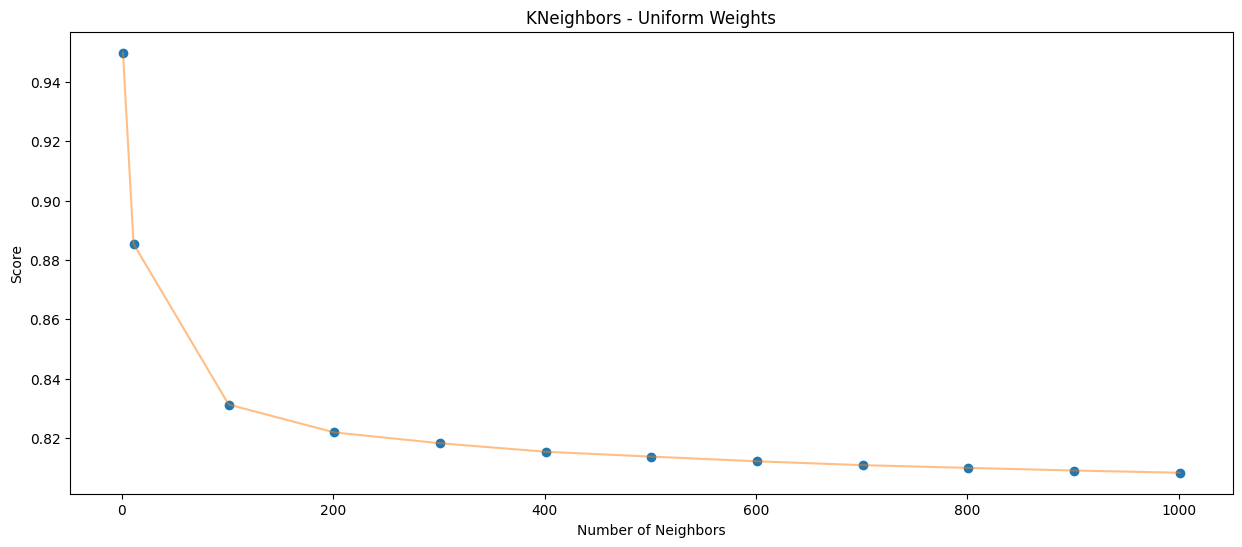

In [ ]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(n_neighbors , uniform_scores , 'o')
plt.plot(n_neighbors , uniform_scores , '-' , alpha = 0.5)
plt.xlabel('Number of Neighbors') , plt.ylabel('Score')
plt.title('KNeighbors - Uniform Weights')
plt.show()

In [ ]:
#final knn model, evaluating using test set
knn = KNeighborsClassifier(n_neighbors=501, weights='uniform')
knn.fit(knn_X_train, ph_y_train)
score = knn.score(knn_X_test, ph_y_test)
score

0.8136364522227203

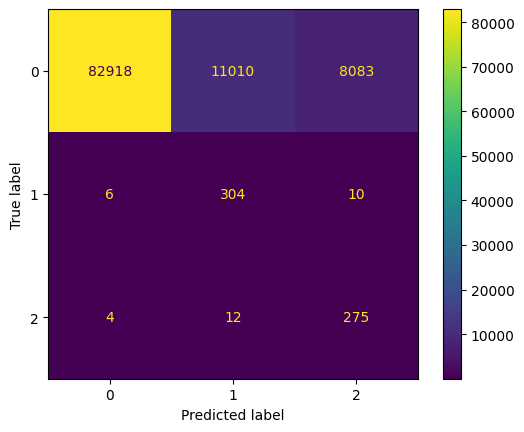

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90    102011
         1.0       0.03      0.95      0.05       320
         2.0       0.03      0.95      0.06       291

    accuracy                           0.81    102622
   macro avg       0.35      0.90      0.34    102622
weighted avg       0.99      0.81      0.89    102622



In [ ]:
# Confusion Matrix
knn_y_pred = knn.predict(knn_X_test)
cm = confusion_matrix(ph_y_test, knn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(classification_report(ph_y_test,knn_y_pred))

# Logistic Regression

## 1. Phenophase

In [ ]:
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
for solver in solvers:
    score, clf, preds, cm = (None,)*4
    clf = LogisticRegression(random_state=random_state, multi_class='multinomial', solver=solver, max_iter=1000).fit(ph_X_train, ph_y_train)
    score = clf.score(ph_X_validate, ph_y_validate)
    preds = clf.predict(ph_X_validate)
    cm = confusion_matrix(ph_y_validate, preds)
    print('Solver ' + solver + ' returns a score of ' + str(round(score,5)))
    print(cm)

/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
Solver newton-cg returns a score of 0.66646
[[67956 17559 16551]
 [   52   239    23]
 [   28    15   198]]
Solver sag returns a score of 0.66643
[[67952 17581 16533]
 [   52   239    23]
 [   27    15   199]]
Solver saga returns a score of 0.66624
[[67932 17603 16531]
 [   52   239    23]
 [   27    15   199]]
Solver lbfgs returns a score of 0.66499
[[67805 17653 16608]
 [   49   241    24]
 [   27    18   196]]


None of the models have good scores and seem to be about equal. We will go with the default lbfgs solver.

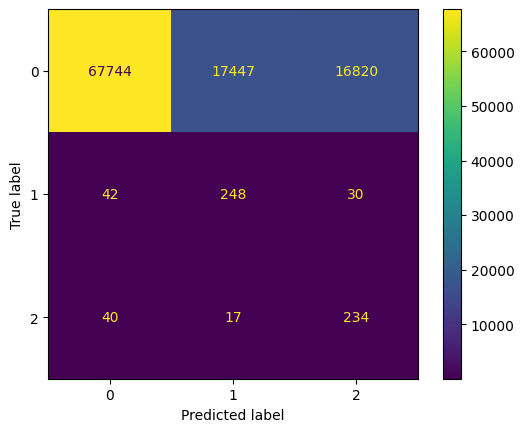

Score: 0.665
              precision    recall  f1-score   support

         0.0       1.00      0.66      0.80    102011
         1.0       0.01      0.78      0.03       320
         2.0       0.01      0.80      0.03       291

    accuracy                           0.66    102622
   macro avg       0.34      0.75      0.28    102622
weighted avg       0.99      0.66      0.79    102622



In [ ]:
log_clf = LogisticRegression(random_state=random_state, multi_class='multinomial', max_iter=1000).fit(ph_X_train, ph_y_train)
score = log_clf.score(ph_X_test, ph_y_test)

#confusion matrix
log_ph_prediction = log_clf.predict(ph_X_test)
cm = confusion_matrix(ph_y_test, log_ph_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score: ' + str(round(score,3)))
print(classification_report(ph_y_test,log_ph_prediction))

This model is pretty inaccurate, perhaps because of overlap between first bloom and leaf weather requirements, so we will instead explore using separate models to predict first leaf and first bloom.

## 2. First Leaf

In [ ]:
#SMOTE
lf_y_train_0 = train['First_leaf']
lf_X_train_0 = train.drop(['First_bloom', 'First_leaf', 'Phenophase'], axis = 1)
smote = SMOTE(random_state=random_state)
lf_X_train, lf_y_train = smote.fit_resample(lf_X_train_0, lf_y_train_0)
print(f'''Shape of X before SMOTE: {lf_X_train_0.shape}
Shape of X after SMOTE: {lf_X_train.shape}''')

Shape of X before SMOTE: (478899, 4)
Shape of X after SMOTE: (955052, 4)


In [ ]:
#splitting validate and test sets
lf_y_validate = validate['First_leaf']
lf_X_validate = validate.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)

lf_y_test = test['First_leaf']
lf_X_test = test.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)

In [ ]:
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
for solver in solvers:
    score, clf, preds, cm = (None,)*4
    clf = LogisticRegression(random_state=random_state, solver=solver, max_iter=1000).fit(lf_X_train, lf_y_train)
    score = clf.score(lf_X_validate, lf_y_validate)
    preds = clf.predict(lf_X_validate)
    cm = confusion_matrix(lf_y_validate, preds)
    print('Solver ' + solver + ' returns a score of ' + str(round(score,5)))
    print(cm)

Solver liblinear returns a score of 0.80854
[[82715 19592]
 [   56   258]]
Solver newton-cg returns a score of 0.80869
[[82730 19577]
 [   55   259]]
Solver lbfgs returns a score of 0.80868
[[82729 19578]
 [   55   259]]
Solver sag returns a score of 0.80857
[[82718 19589]
 [   56   258]]
Solver saga returns a score of 0.80859
[[82720 19587]
 [   56   258]]


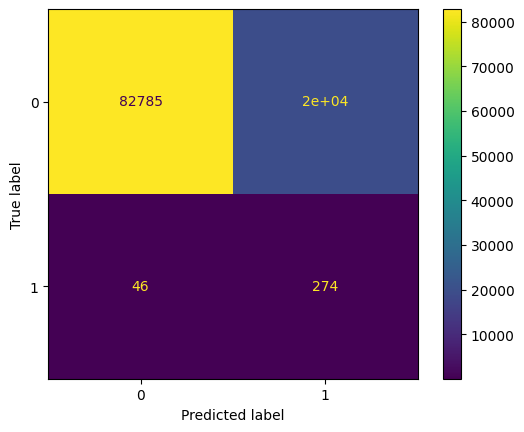

Score: 0.809
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89    102302
         1.0       0.01      0.86      0.03       320

    accuracy                           0.81    102622
   macro avg       0.51      0.83      0.46    102622
weighted avg       1.00      0.81      0.89    102622



In [ ]:
#final leaf log reg, using test set
clf = LogisticRegression(random_state=random_state, max_iter=1000).fit(lf_X_train, lf_y_train)
score = clf.score(lf_X_test, lf_y_test)

#confusion matrix
#get predictions for test set
leaf_prediction = clf.predict(lf_X_test)
cm = confusion_matrix(lf_y_test, leaf_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score: ' + str(round(score,3)))
print(classification_report(lf_y_test,leaf_prediction))

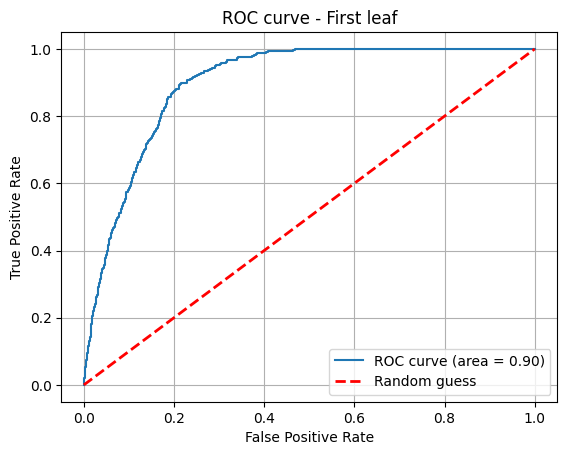

AUC Score: 0.8983886861938184


In [ ]:
#predict first leaf based on weather in validate df
log_lf_y_pred = clf.predict_proba(lf_X_test)[:, 1]

#get area under the curve for the model
auc=roc_auc_score(lf_y_test,log_lf_y_pred)

#false and true positive rates for ROC curve
fpr, tpr, _ = roc_curve(lf_y_test,  log_lf_y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess') #plot line for random guess
plt.title('ROC curve - First leaf')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC Score: ' + str(auc))

## 3. First Bloom

In [ ]:
#SMOTE
bl_y_train_0 = train['First_bloom']
bl_X_train_0 = train.drop(['First_bloom', 'First_leaf', 'Phenophase'], axis = 1)
smote = SMOTE(random_state=random_state)
bl_X_train, bl_y_train = smote.fit_resample(bl_X_train_0, bl_y_train_0)
print(f'''Shape of X before SMOTE: {bl_X_train_0.shape}
Shape of X after SMOTE: {bl_X_train.shape}''')

Shape of X before SMOTE: (478899, 4)
Shape of X after SMOTE: (955302, 4)


In [ ]:
#splitting validate and test sets
bl_y_validate = validate['First_bloom']
bl_X_validate = validate.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)

bl_y_test = test['First_bloom']
bl_X_test = test.drop(['Phenophase', 'First_leaf', 'First_bloom'], axis = 1)

In [ ]:
solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
for solver in solvers:
    score, clf, preds, cm = (None,)*4
    clf = LogisticRegression(random_state=random_state, solver=solver, max_iter=1000).fit(bl_X_train, bl_y_train)
    score = clf.score(bl_X_validate, bl_y_validate)
    preds = clf.predict(bl_X_validate)
    cm = confusion_matrix(bl_y_validate, preds)
    print('Solver ' + solver + ' returns a score of ' + str(round(score,5)))
    print(cm)

Solver liblinear returns a score of 0.77232
[[79041 23339]
 [   26   215]]
Solver newton-cg returns a score of 0.77248
[[79058 23322]
 [   26   215]]
Solver lbfgs returns a score of 0.77248
[[79058 23322]
 [   26   215]]
Solver sag returns a score of 0.77236
[[79045 23335]
 [   26   215]]
Solver saga returns a score of 0.77221
[[79030 23350]
 [   26   215]]


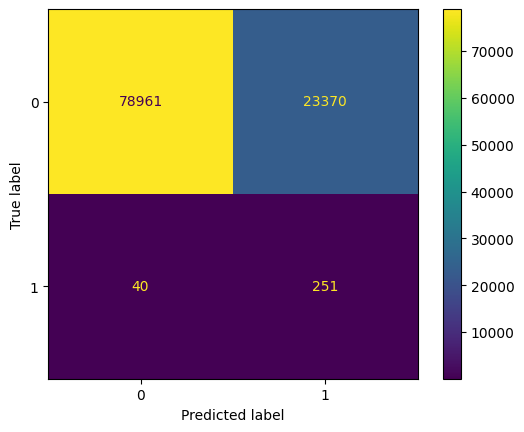

Score: 0.772
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87    102302
         1.0       0.01      0.76      0.02       320

    accuracy                           0.77    102622
   macro avg       0.50      0.76      0.45    102622
weighted avg       1.00      0.77      0.87    102622



In [ ]:
#final bloom log reg, using test set
clf = LogisticRegression(random_state=random_state, max_iter=1000).fit(bl_X_train, bl_y_train)
score = clf.score(bl_X_test, bl_y_test)

#confusion matrix
#get predictions for test set
bloom_prediction = clf.predict(bl_X_test)

cm = confusion_matrix(bl_y_test, bloom_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score: ' + str(round(score,3)))
print(classification_report(lf_y_test,bloom_prediction))

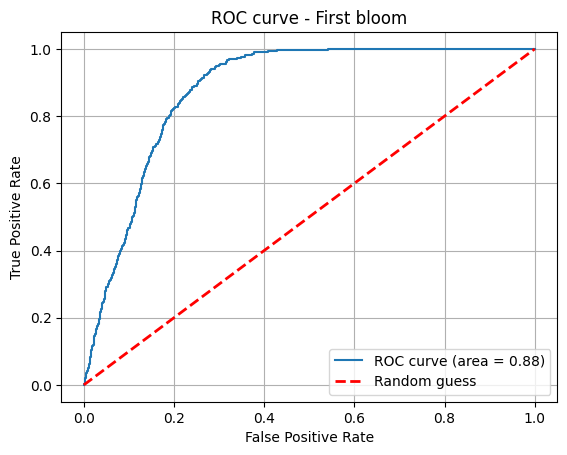

AUC Score: 0.878801729620686


In [ ]:
#ROC Curve
#predict first bloom probability based on weather in validate df
log_bl_y_pred = clf.predict_proba(bl_X_test)[:,1]

#get area under the curve for the model
auc=roc_auc_score(bl_y_test,log_bl_y_pred )

#false and true positive rates for ROC curve
fpr, tpr, _ = roc_curve(bl_y_test,  log_bl_y_pred)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess') #plot line for random guess
plt.title('ROC curve - First bloom')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.show()
print('AUC Score: ' + str(auc))

So separating them makes the logistic regression model work much better, with good performance by both. 

# Random Forest/Decision Tree

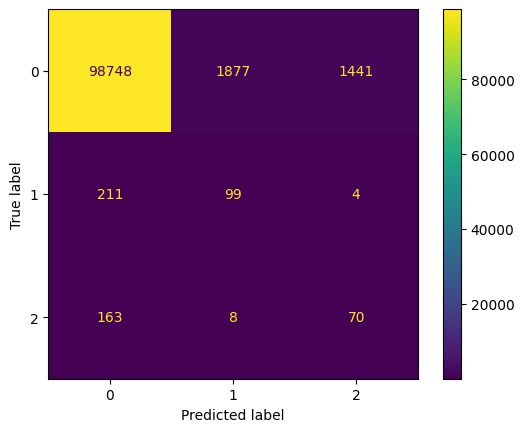

Score: 0.964


In [ ]:
#base decision tree model
tree_clf = DecisionTreeClassifier(random_state=random_state).fit(ph_X_train, ph_y_train)
score = tree_clf.score(ph_X_validate, ph_y_validate)

#base model confusion matrix
tree_y_pred = tree_clf.predict(ph_X_validate)
cm = confusion_matrix(ph_y_validate, tree_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score: ' + str(round(score,3)))

A single tree had a very high score but also a large number of false positives and negatives, indicative that it may have been overfitted to the training set. We will create a confusion matrix using the training set to see if this is the case. 

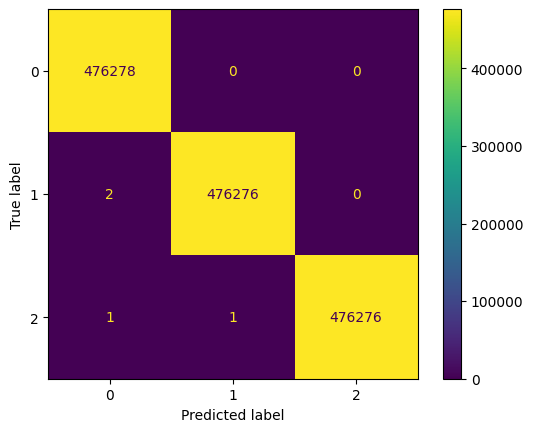

Score: 0.9999972005145454


In [ ]:
#base model confusion matrix
tree_y_pred = tree_clf.predict(ph_X_train)
cm = confusion_matrix(ph_y_train, tree_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score: ' + str(tree_clf.score(ph_X_train, ph_y_train)))

A single tree memorized the training set to the point of being overfit. It can almost perfectly predict the data it was trained on, but performs poorly when given new data. To mitigate overfitting, we will use a random forest and cap the maximum depth of the trees.

While it would be better to use more estimators in our forest, this takes too long to compute so we will only use 100 estimators instead.

In [ ]:
#find optimimum max depth
for i in list(range(3,11)):
    clf, score, y_pred, cm = (None,)*4
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state, max_depth=i).fit(ph_X_train, ph_y_train)
    score = clf.score(ph_X_validate, ph_y_validate)
    y_pred = clf.predict(ph_X_validate)
    cm = confusion_matrix(ph_y_validate, y_pred)
    print((str(i) + ': ', score))
    print(cm)

('3: ', 0.8029350717689362)
[[81885 11439  8742]
 [    7   292    15]
 [    4    16   221]]
('4: ', 0.7963477260989467)
[[81200 12147  8719]
 [    4   298    12]
 [    2    15   224]]
('5: ', 0.8076514553551417)
[[82358 11651  8057]
 [    4   299    11]
 [    2    14   225]]
('6: ', 0.8122703929994836)
[[82833 11151  8082]
 [    5   296    13]
 [    1    13   227]]
('7: ', 0.8172986035996531)
[[83352 10784  7930]
 [    5   295    14]
 [    3    13   225]]
('8: ', 0.8231551047056646)
[[83951 10477  7638]
 [    6   297    11]
 [    3    13   225]]
('9: ', 0.8284269301604935)
[[84493 10133  7440]
 [    7   295    12]
 [    3    12   226]]
('10: ', 0.8339131366874226)
[[85061  9865  7140]
 [   11   292    11]
 [    5    12   224]]


A depth of 5 has the fewest false negatives but given that a depth of 6 only has 1 more and a smaller false positive rate, we will use 6 for our final model.

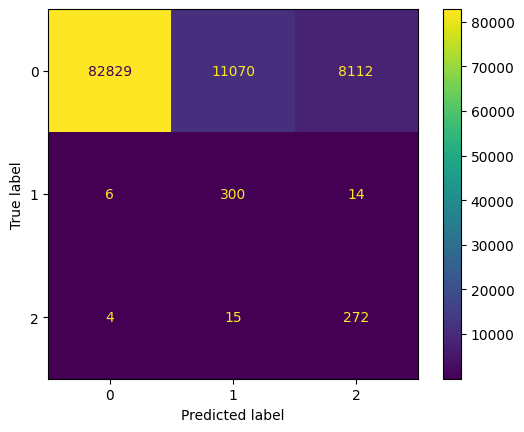

Score:0.813
              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90    102011
         1.0       0.03      0.94      0.05       320
         2.0       0.03      0.93      0.06       291

    accuracy                           0.81    102622
   macro avg       0.35      0.89      0.34    102622
weighted avg       0.99      0.81      0.89    102622



In [ ]:
#final forest model, evaluated using test set
forest_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=random_state, max_depth=6).fit(ph_X_train, ph_y_train)
score = forest_clf.score(ph_X_test, ph_y_test)

#confusion matrix
forest_y_pred = forest_clf.predict(ph_X_test)
cm = confusion_matrix(ph_y_test, forest_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score:' + str(round(score,3)))
print(classification_report(ph_y_test, forest_y_pred))

To contrast this with the model of a single decision tree, we can once again look at how to model performs on the training set.

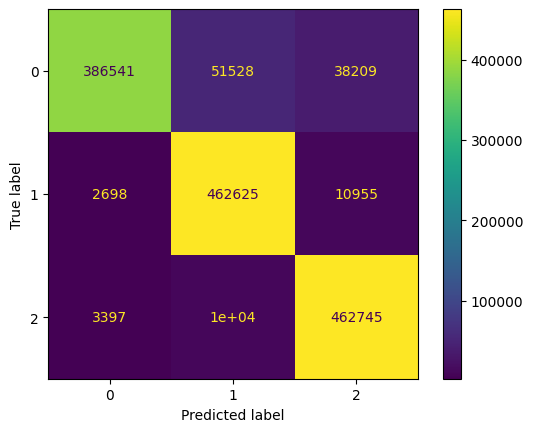

Score: 0.9181689405487271


In [ ]:
#confusion matrix
forest_y_pred = forest_clf.predict(ph_X_train)
cm = confusion_matrix(ph_y_train, forest_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Score: ' + str(forest_clf.score(ph_X_train, ph_y_train)))

While the forest's accuracy is still very high, we can see its not as perfect as the single tree. Rather than perfectly memorizing the training set, it is able to generalize better.

# 5-Fold Cross Validation

Our data will be split into 5 folds to compare between our final models. These training sets will also need to be balanced using smote.

In [ ]:
X = df.drop(columns=['First_leaf', 'First_bloom', 'Phenophase'])
y = df['Phenophase'] 
kf = KFold(n_splits=5, random_state=random_state, shuffle=True)

In [ ]:
models = [('KNN', knn), ('Logistic Regression', log_clf), ('Random Forest', forest_clf)]

results = []
fold=1
for train_index, test_index in kf.split(X):
    CV_X_train, CV_X_test, CV_y_train, CV_y_test = (None,)*4
    
    #split data
    CV_X_train, CV_X_test = X.iloc[train_index], X.iloc[test_index]
    CV_y_train, CV_y_test = y.iloc[train_index], y.iloc[test_index]

    #retrain and test models
    for model_name, model in models:
        CV_model, CV_score, CV_preds, CV_report, accuracy, precision, recall, f1 = (None,)*8
        #knn needs to be scaled
        if model_name=='KNN':
            scaler = StandardScaler()
            CV_X_train = scaler.fit_transform(CV_X_train)
            CV_X_test = scaler.transform(CV_X_test)
        else:
            pass

        #must resample training to balance classes
        smote = SMOTE(random_state=random_state)
        CV_X_train, CV_y_train = smote.fit_resample(CV_X_train, CV_y_train)

        #train and evaluate model    
        CV_model = model.fit(CV_X_train,CV_y_train)
        CV_score = CV_model.score(CV_X_test,CV_y_test)
        CV_preds = CV_model.predict(CV_X_test)
        CV_report = classification_report(CV_y_test, CV_preds, output_dict=True)
        precision =  CV_report['macro avg']['precision'] 
        recall = CV_report['macro avg']['recall']    
        f1 = CV_report['macro avg']['f1-score']
        results.append((model_name, CV_score, precision, recall, f1))
    fold += 1

In [ ]:
#put results together
results_df = pd.DataFrame(results, columns =['Model', 'Score', 'Precision', 'Recall', 'F1_Score'])

In [ ]:
#find the average results
avg_results = results_df.groupby(['Model']).mean()
avg_results

,Score,Precision,Recall,F1_Score
Model,,,,
KNN,0.816431,0.351706,0.892340,0.335286
Logistic Regression,0.665403,0.341660,0.754234,0.283183
Random Forest,0.812988,0.351720,0.898880,0.334572


In [ ]:
#find the std of the results
std_results = results_df.groupby(['Model']).std()
std_results

,Score,Precision,Recall,F1_Score
Model,,,,
KNN,0.001386,0.000843,0.007914,0.001498
Logistic Regression,0.002041,0.000397,0.013348,0.001176
Random Forest,0.001690,0.001025,0.005012,0.001943


# Deeper Analysis - Feature Importance

Text(0.5, 1.0, 'Feature Importance - Random Forest')

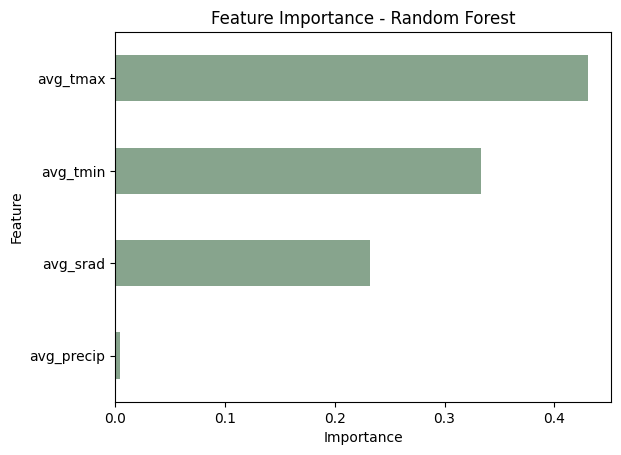

In [ ]:
feature_importance = pd.Series(forest_clf.feature_importances_, index=ph_X_train.columns)
feature_importance = feature_importance.sort_values(ascending=True)
feature_importance.plot.barh(color='#87A48D')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6bbd9398-18f2-46ef-ba4f-be9bc7f4116a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>